In [9]:
%cd '../z20_data/Spanner.v1i.createml/train/'

[WinError 3] 지정된 경로를 찾을 수 없습니다: "'../z20_data/Spanner.v1i.createml/train/'"
c:\workspace\medical1\p0612


In [ ]:
from roboflow import Roboflow

In [5]:
# roboflow에서 다운 받을 데이터셋 명세
USER_NAME = 'malek-mhnrl'
PROJECT_NAME = 'x-ray-baggage-detection'
VERSION = 1

rf = Roboflow(api_key='rf_4ZuCrZxw2IegYomEt8aupDiN6ED3')
project = rf.workspace(USER_NAME).project(PROJECT_NAME)
dataset = project.version(VERSION).download('voc')

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to X-ray-baggage-detection-1 in voc:: 100%|██████████| 17665/17665 [00:02<00:00, 6895.22it/s]


In [6]:
!pip install xmltodict

In [7]:
import os
from glob import glob
from tqdm.notebook import tqdm_notebook as tqdm
import pandas as pd
import seaborn as sns
import xmltodict as xmd

In [8]:
class_name = {
    1: 'Scissor',
    2: 'Pocket knife',
    3: 'Knife',
    4: 'Utility knife',
    5: 'Multipurpose knife'
}

NUM_CLASSES = len(class_name) + 1

In [11]:
def load_from_directory(path):
    if os.path.isfile(path+'/annot.csv'):
        df = pd.read_csv(path+'/annot.csv')
        print(f"Loaded {path+'/annot.csv'}")
    else:
        df = pd.DataFrame(columns=['img', 'xml'])
        flist = glob(path+'/*.jpg')

        for i, img in tqdm(enumerate( flist), total=len(flist), desc=f'Loading data from {path}...' ):
            xml = img[:-3] + 'xml'
            df.loc[i] = [img, xml]

        df.to_csv(path+'/annot.csv', index=False)

    return df

train_df = load_from_directory('./X-ray-baggage-detection-1/train')
valid_df = load_from_directory('./X-ray-baggage-detection-1/valid')
test_df  = load_from_directory('./X-ray-baggage-detection-1/test')

Loading data from ./X-ray-baggage-detection-1/train...:   0%|          | 0/6181 [00:00<?, ?it/s]

Loading data from ./X-ray-baggage-detection-1/valid...:   0%|          | 0/1766 [00:00<?, ?it/s]

Loading data from ./X-ray-baggage-detection-1/test...:   0%|          | 0/883 [00:00<?, ?it/s]

In [ ]:
train_df.head(3)

In [18]:
import cv2
import torch
import torchvision
import numpy as np
from torch.utils.data import Dataset

In [14]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [15]:
class Data_Structure(Dataset):
  def __init__(self, dataframe):
      self.dataframe = dataframe
      self.image_ids = self.dataframe.index

  def __len__(self):
      return len(self.image_ids)

  def __getitem__(self, idx):
      image_id = self.dataframe.index[idx]
      fname, xml = self.dataframe.loc[idx]

      image = cv2.imread(fname, cv2.IMREAD_COLOR)[:,:,::-1].copy()

      image = cv2.resize( image , (512,512), cv2.INTER_LINEAR) / 255.

      # XML annotation 불러오기 및 dict타입 구성
      with open(xml, 'r') as f:
        annot = xmd.parse( f.read() )['annotation']

      width, height = int( annot['size']['width'] ), int(annot['size']['height'])
      object_class = int( annot['object']['name'] ) + 1 #클래스 값 변경: 0~4 -> 1~5

      xmin, xmax, ymin, ymax = [int( annot['object']['bndbox'][value] ) for value in annot['object']['bndbox']]

      # Bounding box normalization => 0~1
      boxes = np.array([ [xmin, ymin, xmax, ymax] ], dtype = np.float32)
      bbox_w, bbox_h = boxes[0,2]-boxes[0,0], boxes[0,3]-boxes[0,1]
      boxes[0,::2]   = boxes[0, ::2]  / width  * 512
      boxes[0,1::2]  = boxes[0, 1::2] / height * 512

      # classification
      labels =[ object_class ]

      # 학습용 레이블 데이터 생성
      target = {
          'image_id': torch.as_tensor(image_id),

          # Bounding box 좌표 구성은 numpy array -> (Number, xmin, ymin, xmax, ymax)
          # 데이터셋에서 탐지할 object 수에 맞춰서 수정 -> (1, xmin, ymin, xmax, ymax) -> 1: 현재 사용하는 데이터의 탐지 객체 수
          'boxes': torch.from_numpy(boxes),

          # 레이블 클래스 부여
          # 이미지에 탐지 객체의 레이블이 여러개 존재할 경우 여러 값 작성 -> 3개 객체가 있을 경우 순서에 맞춰서 [1, 3, 2], [1, 1, 1]...
          'labels': torch.as_tensor(labels),
          'area'  : torch.as_tensor([bbox_w * bbox_h]),
          'iscrowd': torch.from_numpy(np.zeros(1))
      }

      return (
          torch.from_numpy(image).float().permute(2,0,1), # 순서 변경 ->(channel, horizontal, vertical)
          target
      )

In [16]:
TRAIN_DATA = Data_Structure(train_df)
VAL_DATA = Data_Structure(valid_df)

In [17]:
TRAIN_DATA[0]

(tensor([[[0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
          [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
          [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
          ...,
          [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
          [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
          [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961]],
 
         [[0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
          [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
          [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
          ...,
          [1.0000, 1.0000, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
          [1.0000, 1.0000, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
          [1.0000, 1.0000, 0.9961,  ..., 0.9961, 0.9961, 0.9961]],
 
         [[0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
          [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
          [0.9961, 0.9961, 0.9961,  ...,

In [19]:
def Preview(data, model=None, device='cuda', iou_threshold=0.5, score_threshold=0):
    plt.figure(figsize=(12,12))
    plt.imshow(data[0].permute(1,2,0).numpy())
    ax = plt.gca()
    for i,box in enumerate(data[1]['boxes']):
        x1,y1, x2, y2 = box
        ground_truth = Rectangle(
                            (x1,y1),
                            x2-x1, y2-y1,
                            edgecolor='blue',
                            linewidth=3,
                            fill=False )
        ax.add_patch(ground_truth)
        plt.text(10, 10, f'[Ground Truth]:' + f"{class_name[data[1]['labels'][i].item()]}", color='blue', fontsize=12)

    if model is not None:
        model.eval()
        rtn = model( torch.unsqueeze( data[0], 0 ).to(device) ) # 차원 확장
        class_pred = rtn[0]['labels'].detach().cpu()
        bbox = rtn[0]['boxes'].detach().cpu()
        scores = rtn[0]['scores'].detach().cpu()
        get = torchvision.ops.nms(boxes=bbox, scores=scores, iou_threshold=iou_threshold)

        for i, pred in enumerate(class_pred):
            if i not in get: continue
            if scores[i]<score_threshold: continue

            x1,y1, x2, y2 = bbox[i]
            prediction =  Rectangle(
                                (x1,y1), x2-x1,  y2-y1,
                                edgecolor='red', linewidth=3, fill=False )
            ax.add_patch( prediction )
            plt.text(10, 20+10*i, f'[Prediction]  : {class_name[pred.item()]} - {scores[i]:.4f}', color='red', fontsize=12)
    plt.show()

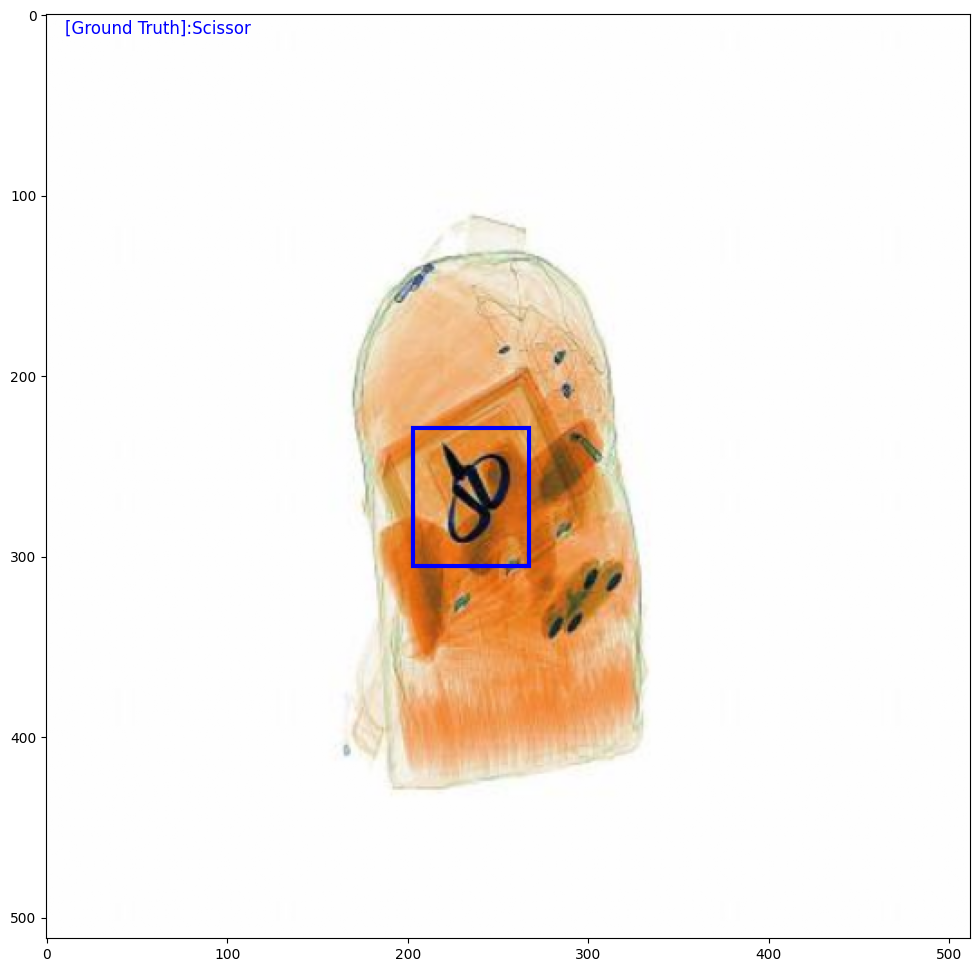

In [23]:
Preview(TRAIN_DATA[99])

In [24]:
from torch.utils.data import DataLoader

In [25]:
BATCH_SIZE = 8
NUM_WORKERS = 8

In [26]:
def collate_fn(batch):
    return tuple(zip(*batch)) # 다양한 크기의 shape를 다루기 위해 조정

In [27]:
train_loader = DataLoader(TRAIN_DATA,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=NUM_WORKERS,
                          collate_fn=collate_fn)

val_loader = DataLoader(VAL_DATA,
                        batch_size=4,
                        shuffle=False,
                        num_workers=NUM_WORKERS,
                        collate_fn=collate_fn)

This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


In [29]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [30]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights=None, min_size=512, max_size=512)

In [31]:
in_features = model.roi_heads.box_predictor.cls_score.in_features
print(in_features)

1024


In [32]:
model = model.to('cuda')

In [37]:
# torchvision 코드를 받아 사용 - 일부 수정된 코드를 받아서 사용합니다.
!git clone https://github.com/Adrian123K/torch_ref

Cloning into 'torch_ref'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 14 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (14/14), 22.28 KiB | 2.47 MiB/s, done.


In [38]:
import sys
sys.path.append('./torch_ref/torchvision_ref') # 경로 추가

In [39]:
import torch_ref.torchvision_ref.engine as engine

In [40]:
# Params: 가중치 업데이트
params = [p for p in model.parameters() if p.requires_grad]

# SGD Optimizer
optimizer = torch.optim.SGD(params, lr=0.01, weight_decay=0.0005)

# lr_scheduler로 현재 learning rate를 3에폭 마다 95%로 감소
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.95)

In [ ]:
num_epochs = 3

for epoch in range(num_epochs):
    engine.train_one_epoch(model, optimizer, train_loader, 'cuda', epoch, print_freq=50)

    # lr_scheduler 실행
    lr_scheduler.step()

    engine.evaluate(model, val_loader, device='cuda')
    torch.save(model.state_dict(), f"./last_epoch_model.pth")

This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


Epoch: [0]  [  0/773]  eta: 1:09:13  lr: 0.000023  loss: 5.2752 (5.2752)  loss_classifier: 4.5468 (4.5468)  loss_box_reg: 0.0262 (0.0262)  loss_objectness: 0.6959 (0.6959)  loss_rpn_box_reg: 0.0063 (0.0063)  time: 5.3738  data: 1.2092  max mem: 7638
Epoch: [0]  [ 50/773]  eta: 0:17:19  lr: 0.000670  loss: 2.2113 (3.7859)  loss_classifier: 1.4710 (3.0551)  loss_box_reg: 0.0233 (0.0264)  loss_objectness: 0.6937 (0.6948)  loss_rpn_box_reg: 0.0084 (0.0096)  time: 1.3807  data: 0.0489  max mem: 7644
Epoch: [0]  [100/773]  eta: 0:15:59  lr: 0.001317  loss: 0.8293 (2.3818)  loss_classifier: 0.1152 (1.6561)  loss_box_reg: 0.0165 (0.0240)  loss_objectness: 0.6860 (0.6918)  loss_rpn_box_reg: 0.0071 (0.0100)  time: 1.4418  data: 0.0535  max mem: 7644
